In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import geopandas as gpd

%matplotlib inline
DATA_FILE = 'uber-raw-data-aug14.csv'

uber_data = pd.read_csv(DATA_FILE)

uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data['DayOfWeekNum'] = uber_data['Date/Time'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.weekday_name
uber_data['MonthDayNum'] = uber_data['Date/Time'].dt.day
uber_data['HourOfDay'] = uber_data['Date/Time'].dt.hour
uber_data['ChunkIndex'] = 4*uber_data['HourOfDay'] + uber_data['Date/Time'].dt.minute // 15 # which 15-minute block within the day is it in

uber_data.head()


#829275 entries

,Date/Time,Lat,Lon,Base,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,ChunkIndex
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,4,Friday,1,0,0
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,4,Friday,1,0,0
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,4,Friday,1,0,0
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,4,Friday,1,0,0
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,4,Friday,1,0,0


In [2]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 9 columns):
Date/Time       829275 non-null datetime64[ns]
Lat             829275 non-null float64
Lon             829275 non-null float64
Base            829275 non-null object
DayOfWeekNum    829275 non-null int64
DayOfWeek       829275 non-null object
MonthDayNum     829275 non-null int64
HourOfDay       829275 non-null int64
ChunkIndex      829275 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 56.9+ MB


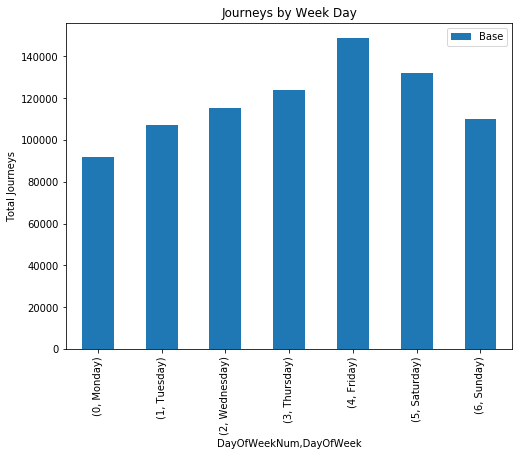

In [3]:
uber_weekdays = uber_data.pivot_table(index=['DayOfWeekNum', 'DayOfWeek'],
                                  values='Base',
                                  aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day');

In [4]:
# Not displaying anything for now

# gdf = gpd.GeoDataFrame(
#     uber_data, geometry=gpd.points_from_xy(uber_data.Lon, uber_data.Lat))
# # gdf.head()

# gdf.crs = {'init': 'epsg:4326'}
# print(gdf.head())

# gdf = gdf.to_crs({'init': 'epsg:3395'})
# print(gdf.head())



In [5]:
from haversine import haversine

# x is lat space, y is lon space
min_lat, min_lon = min(uber_data['Lat']), min(uber_data['Lon'])
max_lat, max_lon = max(uber_data['Lat']), max(uber_data['Lon'])

max_x_dist = haversine((min_lat, min_lon), (max_lat, min_lon))
max_y_dist = haversine((min_lat, min_lon), (min_lat, max_lon))

x_nums, y_nums = 1000, 1000 # of cells in each axis
x_cell_size = max_x_dist / x_nums # in km
y_cell_size = max_y_dist / y_nums # in km

def cluster_coordinate(lat, lon):
    x_dist = haversine((min_lat, min_lon), (lat, min_lon))# dist along lat
    y_dist = haversine((min_lat, min_lon), (min_lat, lon))# dist along lon
    
    return x_dist // x_cell_size, y_dist // y_cell_size


# print(min_lat, max_lat)
# print(min_lon, max_lon)
# print()
# cluster_coordinate(40.7366, -73.9906)

# uber_data.head()
# 

In [6]:
# add cluster coordinates to all entries in uber data
uber_data['ClusterCoordinateX'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[0]), axis=1)
uber_data['ClusterCoordinateY'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[1]), axis=1)


In [7]:
# TESTS

# uber_data[uber_data['ClusterCoordinateX'] == 594][uber_data['ClusterCoordinateY']==406]

In [8]:

# count rides per 15-minute chunk for each (chunkindex, monthdaynum, dayofweeknum, coordX, coordY) as key
uber_rides_count = uber_data.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'DayOfWeekNum', 'MonthDayNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='count')
uber_rides_count.head()


,,,,,Base
ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,
0,224,4,1,78,1
7,251,5,23,54,1
158,271,5,23,92,1
169,287,6,31,6,1
173,261,3,14,77,1


In [2]:
# START TRAINING STUFF HERE

# write uber data to output file
TRAIN_FILE = 'training.csv'
uber_rides_count.to_csv(TRAIN_FILE)

NameError: name 'uber_rides_count' is not defined

In [3]:
# NOW START TRAINING ---------------
dataset = pd.read_csv(TRAIN_FILE)
dataset.head()

,ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,Base
0,0,224,4,1,78,1
1,7,251,5,23,54,1
2,158,271,5,23,92,1
3,169,287,6,31,6,1
4,173,261,3,14,77,1


In [4]:
dataset.loc[dataset['Base'].idxmax()]
# this ends up being JFK airport which seems accurate

ClusterCoordinateX    594
ClusterCoordinateY    406
DayOfWeekNum            0
MonthDayNum             4
ChunkIndex             21
Base                   30
Name: 12525, dtype: int64

In [5]:
# stats for 15-minute increments
print('Min rides: {}, max rides: {}'.format(min(dataset['Base']), max(dataset['Base'])))
print('Average rides: {}'.format(dataset['Base'].mean()))
print('stddev rides: {}'.format(dataset['Base'].std()))

Min rides: 1, max rides: 30
Average rides: 1.264152208941254
stddev rides: 0.7060573772139869


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


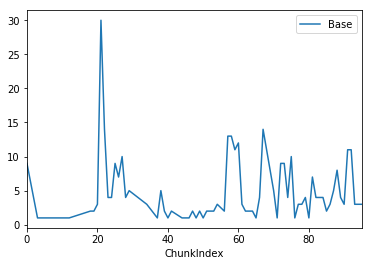

In [6]:
example_test = dataset[dataset['ClusterCoordinateX']==594][dataset['ClusterCoordinateY']==406][dataset['DayOfWeekNum']==0][dataset['MonthDayNum']==4].sort_values(by=['ChunkIndex'])
example_test.plot(x='ChunkIndex', y='Base')



In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
print(pca.fit_transform(dataset))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[[ 639.47023414   42.75235289  153.12657762]
 [ 621.27675247   70.02602011  170.08291008]
 [ 476.59563202   17.31119417  139.53524644]
 ...
 [-340.4318731   -25.35985761  -21.02481117]
 [-293.11032938  -81.00715589 -182.33657666]
 [-367.3157566   -26.79836845  -21.45144931]]
[0.37711713 0.29447117 0.28762807]
0.9592163792113859


In [20]:
# TRAINING STARTS

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# split dataset into (train, test)
# For now, splitting on all data tuples, not separating based on cluster
def split(dataset, train_fraction):
    msk = np.random.rand(len(dataset)) < train_fraction
    return dataset[msk], dataset[~msk]

train, test = split(dataset, .7)
features = dataset.columns[:5] # coordX, coordY, dayofweeknum, monthdaynum, chunkindex



In [ ]:
# models
randf = RandomForestClassifier(n_estimators=20)
randf.fit(train[features], train['Base'])


In [22]:
# models
log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500)
log_reg.fit(train[features], train['Base'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# expected
expect = test['Base']

# predictions
randf_pred = randf.predict(test[features])
log_reg_pred = log_reg.predict(test[features])


confusion = pd.crosstab(expect, randf_pred, rownames=['Actual'], colnames=['Predicted'])
confusion

# print(list(zip(train[features], clf.feature_importances_)))

Predicted,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,20,21,23
Actual,,,,,,,,,,,,,,,,,,,,,
1,158058,2031,354,85,40,12,8,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2,7883,18414,200,85,28,6,4,6,3,1,...,0,0,1,0,0,0,0,0,0,0
3,1555,325,4249,42,14,6,9,2,2,0,...,0,0,0,0,0,0,0,0,0,0
4,381,112,63,1355,9,9,5,5,1,1,...,0,0,0,0,0,0,0,0,0,0
5,98,44,21,13,444,8,4,3,2,2,...,0,0,0,0,0,0,0,0,0,0
6,30,16,12,8,3,190,3,1,0,0,...,1,0,0,0,0,0,0,0,0,0
7,8,7,12,7,4,2,110,2,4,0,...,0,0,0,0,0,0,0,0,0,0
8,6,2,2,5,5,2,2,63,2,0,...,2,0,0,0,0,0,0,0,0,0
9,2,3,5,2,1,1,0,1,33,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# metrics

from sklearn.metrics import mean_squared_error, accuracy_score

expected = np.array(expect)

print("RANDF mean_squared_error: {}".format(mean_squared_error(expected, randf_pred)))
print("RANDF accuracy: {}".format(accuracy_score(expected, randf_pred)))
print()

print("LOGREG mean_squared_error: {}".format(mean_squared_error(expected, log_reg_pred)))
print("LOGREG accuracy: {}".format(accuracy_score(expected, log_reg_pred)))
print()

RANDF mean_squared_error: 0.17348791091449928
RANDF accuracy: 0.9304350036864719

LOGREG mean_squared_error: 0.5726641751201281
LOGREG accuracy: 0.8163831896880482



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


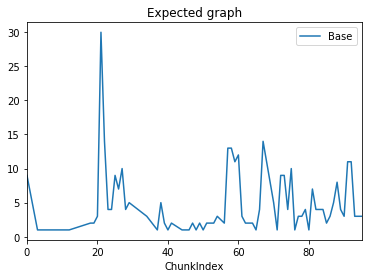

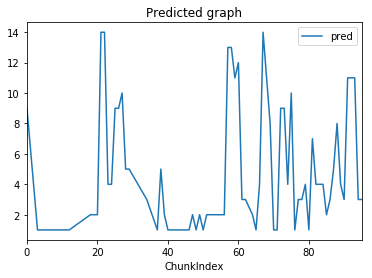

In [42]:
# example of running the model
# coordX, coordY, dayofweeknum, monthdaynum, chunkindex

# plot predicted nums, and true nums for each chunkindex

# ClusterCoordinateX	ClusterCoordinateY	DayOfWeekNum	MonthDayNum	ChunkIndex	Base
def visualize(coordx, coordy, dayofweeknum, monthdaynum):
    
    expect = dataset[dataset['ClusterCoordinateX']==coordx][dataset['ClusterCoordinateY']==coordy][dataset['DayOfWeekNum']==dayofweeknum][dataset['MonthDayNum']==monthdaynum].sort_values(by=['ChunkIndex'])
    if expect.empty:
        return
    test_data = np.zeros((len(expect), 5))
    
    test_data[:, 0] = len(expect)*[coordx]
    test_data[:, 1] = len(expect)*[coordy]
    test_data[:, 2] = len(expect)*[dayofweeknum]
    test_data[:, 3] = len(expect)*[monthdaynum]
    test_data[:, 4] = expect['ChunkIndex']
    pred = clf.predict(test_data)
    expect['pred'] = pred
    
    expect.plot(x='ChunkIndex', y='Base', title='Expected graph')
    expect.plot(x='ChunkIndex', y='pred', title='Predicted graph')
    

visualize(594, 406, 0, 4)
#visualize(662, 317, 0, 18)
# visualize(653, 315, 3, 21)
#visualize(672, 369, 6, 17)